#Proyecto: Predicción de Riesgo de Incendios en Córdoba

# **Estructura del notebook**  
# 1. Imports  
# 2. Montaje de Google Drive  
# 3. Carga de datasets  
# 4. Limpieza y parseo  
# 5. Construcción del dataset integrado  
# 6. Análisis Exploratorio de Datos (EDA)  
# 7. Selección de features y preparación de X, y  
# 8. Entrenamiento y evaluación de modelo  
# 9. Visualizaciones finales  


In [ ]:
# 1) IMPORTS (estándar, tercero, local)
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)


In [ ]:
# 1) Instala gdown (solo la primera vez)
!pip install gdown

# 2) Importa y ejecuta la descarga usando el “file ID” de Drive
import gdown
import pandas as pd

# Reemplaza estos IDs con los de tus archivos en Drive
file_id_meteo = "1BKeRWR8KMeYFBoYCuE6rKImJa4wBMxiU"
file_id_ndvi  = "1LQgu7roH8GWJBqRdTNgb8bg5mL5XfwR5"
file_id_fires = "1HeJSNprfNnnVoJQVkVWud6CcGNTa7pBq"
file_id_rii   = "1mQBApyfe2F5Hh-i5pWLLbnoj23HVrSIm"

# Construye la URL de descarga directa
url_meteo = f"https://drive.google.com/uc?export=download&id={file_id_meteo}"
url_ndvi  = f"https://drive.google.com/uc?export=download&id={file_id_ndvi}"
url_fires = f"https://drive.google.com/uc?export=download&id={file_id_fires}"
url_rii   = f"https://drive.google.com/uc?export=download&id={file_id_rii}"

# 3) Descarga cada archivo al entorno local
gdown.download(url_meteo, "variables_meteorologicas_cordoba.csv", quiet=False)
gdown.download(url_ndvi,  "ndvi_cordoba1988_2024.csv", quiet=False)
gdown.download(url_fires, "fire_archive_J1V-C2_598837.csv", quiet=False)
gdown.download(url_rii,   "rii_b_cantidad_incendios_prov_2017_2025.csv", quiet=False)

# 4) Ahora sí, lee cada CSV con pandas
meteo_df = pd.read_csv("variables_meteorologicas_cordoba.csv")
ndvi_df  = pd.read_csv("ndvi_cordoba1988_2024.csv")
fires_df = pd.read_csv("fire_archive_J1V-C2_598837.csv")
rii_df   = pd.read_csv("rii_b_cantidad_incendios_prov_2017_2025.csv", sep=';')

# Verifica que cargó correctamente
print(meteo_df.head())
print(ndvi_df.head())
print(fires_df.head())
print(rii_df.head())


Downloading...
From: https://drive.google.com/uc?export=download&id=1BKeRWR8KMeYFBoYCuE6rKImJa4wBMxiU
To: /content/variables_meteorologicas_cordoba.csv
100%|██████████| 752k/752k [00:00<00:00, 47.6MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1LQgu7roH8GWJBqRdTNgb8bg5mL5XfwR5
To: /content/ndvi_cordoba1988_2024.csv
100%|██████████| 1.52k/1.52k [00:00<00:00, 3.13MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1HeJSNprfNnnVoJQVkVWud6CcGNTa7pBq
From (redirected): https://drive.google.com/uc?export=download&id=1HeJSNprfNnnVoJQVkVWud6CcGNTa7pBq&confirm=t&uuid=98716721-fb3c-472f-8956-b67c6b66fc66
To: /content/fire_archive_J1V-C2_598837.csv
100%|██████████| 130M/130M [00:01<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1mQBApyfe2F5Hh-i5pWLLbnoj23HVrSIm
To: /content/rii_b_cantidad_incendios_prov_2017_2025.csv
100%|██████████| 1.59k/1.59k [00:00<00:00, 3.56MB/s]


  Unnamed: 0  Temp  RH Wspd Rn24  FFMC   DMC     DC   ISI   BUI   FWI
0   1/1/1994  27,8  53    7    0    85    20  139,1     2    28     4
1   2/1/1994  18,2  81    9    9  44,8    11  129,2   0,1  18,1   0,1
2   3/1/1994  24,4  48   33  0,4  82,4  13,9  137,3   7,9  22,2  12,2
3   4/1/1994  27,4  48   30    0  88,4  17,1  145,9  15,3  26,5  22,1
4   5/1/1994  23,6  67    0    0  87,2  18,9  153,9   2,8  28,9   5,9
  system:time_start   NDVI
0      Sep 29, 1986  0.248
1      Sep 16, 1987  0.171
2      Sep 16, 1987  0.177
3       Sep 2, 1988  0.104
4      Sep 11, 1988  0.100
   latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0 -23.97118  -63.79676      299.71  0.42   0.37  2018-04-01       515   
1 -23.99770  -63.77975      297.56  0.42   0.37  2018-04-01       515   
2 -23.99840  -63.77568      297.42  0.42   0.37  2018-04-01       515   
3 -26.25630  -61.37062      313.50  0.39   0.36  2018-04-01       515   
4 -27.32250  -61.34354      302.40  0.39   0.36  2018

In [ ]:

# Visualiza las primeras filas
display(rii_df.head(5))
display(meteo_df.head(5))
display(ndvi_df.head(5))
display(fires_df.head(5))

,jurisdicción,año_2017,año_2018,año_2019,año_2020,año_2021,año_2022,año_2023,año_2024,año_2025
0,Total,895,1193,1503,1743,2339,2650,2217,2735,206
1,Buenos Aires,37,45,39,62,39,60,37,6,7
2,CABA,0,1,0,1,0,0,1,s/d,s/d
3,Catamarca,167,146,318,164,242,188,290,197,12
4,Chaco,18,8,102,215,122,110,6,s/d,s/d


,Unnamed: 0,Temp,RH,Wspd,Rn24,FFMC,DMC,DC,ISI,BUI,FWI
0,1/1/1994,"27,8",53,7,0,85,20,"139,1",2,28,4
1,2/1/1994,"18,2",81,9,9,"44,8",11,"129,2","0,1","18,1","0,1"
2,3/1/1994,"24,4",48,33,"0,4","82,4","13,9","137,3","7,9","22,2","12,2"
3,4/1/1994,"27,4",48,30,0,"88,4","17,1","145,9","15,3","26,5","22,1"
4,5/1/1994,"23,6",67,0,0,"87,2","18,9","153,9","2,8","28,9","5,9"


,system:time_start,NDVI
0,"Sep 29, 1986",0.248
1,"Sep 16, 1987",0.171
2,"Sep 16, 1987",0.177
3,"Sep 2, 1988",0.104
4,"Sep 11, 1988",0.100


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,-23.97118,-63.79676,299.71,0.42,0.37,2018-04-01,515,N20,VIIRS,n,2,284.57,0.50,N,0
1,-23.99770,-63.77975,297.56,0.42,0.37,2018-04-01,515,N20,VIIRS,n,2,277.86,0.53,N,0
2,-23.99840,-63.77568,297.42,0.42,0.37,2018-04-01,515,N20,VIIRS,n,2,277.09,0.53,N,0
3,-26.25630,-61.37062,313.50,0.39,0.36,2018-04-01,515,N20,VIIRS,n,2,289.86,1.03,N,0
4,-27.32250,-61.34354,302.40,0.39,0.36,2018-04-01,515,N20,VIIRS,n,2,290.96,0.59,N,0


In [ ]:
#Obtenemos las dimenciones del DataFrame (Cuantas filas y columnas tiene)
rii_df.shape

(25, 10)

In [ ]:
#Obtenemos las dimenciones del DataFrame (Cuantas filas y columnas tiene)
meteo_df.shape

(11413, 11)

In [ ]:
#Obtenemos las dimenciones del DataFrame (Cuantas filas y columnas tiene)
ndvi_df.shape

(73, 2)

In [ ]:
#Obtenemos las dimenciones del DataFrame (Cuantas filas y columnas tiene)
fires_df.shape

(1577893, 15)

##PREPROCESAMIENTO

Dataset de incendios en cordoba

In [ ]:
#Limpiamos el valor s/d del dataset de incendios del gobierno
rii_df.replace('s/d', np.nan, inplace=True)


In [ ]:
#Filtrado por Cordoba
rii_df_long = rii_df.melt(id_vars=['jurisdicción'], var_name='year', value_name='fires')
rii_df_long['year'] = rii_df_long['year'].str.replace('año_', '').astype(int)
rii_df_long['fires'] = pd.to_numeric(rii_df_long['fires'], errors='coerce')
cordoba = rii_df_long[rii_df_long['jurisdicción'] == 'Córdoba'].copy()
print("="*80)
print("Filtrado por cordoba")
display(cordoba)
print("="*80)

Filtrado por cordoba


,jurisdicción,year,fires
6,Córdoba,2017,56.0
31,Córdoba,2018,50.0
56,Córdoba,2019,64.0
81,Córdoba,2020,96.0
106,Córdoba,2021,71.0
131,Córdoba,2022,144.0
156,Córdoba,2023,140.0
181,Córdoba,2024,52.0
206,Córdoba,2025,NaN


Dataset del Servicio Meteorológico Nacional de Argentina

In [ ]:

#añado nombre en la columna
#Cargar y procesar variables meteorológicas con parsing tolerante de fechas
meteo_df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# Parsear fechas con inferencia y manejo de errores
"""
meteo_df['date'] = pd.to_datetime(
    meteo_df['date'],
    dayfirst=True,
    infer_datetime_format=True,
    errors='coerce'
)
"""

def parse_date(x):
    s = str(x).strip()
    if '/' in s:
        # formato dd/mm/YYYY
        return pd.to_datetime(s, dayfirst=True, format='%d/%m/%Y', errors='coerce')
    else:
        # asume formato YYYYMMDD
        return pd.to_datetime(s, format='%Y%m%d', errors='coerce')
meteo_df['date'] = meteo_df['date'].apply(parse_date)

# Verificar cuántas fechas no fueron parseadas
missing_dates = meteo_df['date'].isna().sum()
print("="*80)

display(f"Fechas no parseadas: {missing_dates}")
#Eliminar filas sin fecha
meteo_df = meteo_df.dropna(subset=['date'])
display(f"Fechas vacias o nulas: {missing_dates}")

# Convertir columnas numéricas
vars_meteo = [
    'Temp','RH','Wspd','Rn24',
    'FFMC','DMC','DC','ISI','BUI','FWI'
]
for col in vars_meteo:
    meteo_df[col] = meteo_df[col].astype(str).str.replace(',','.').astype(float)

# Mostrar estadísticos para asegurar correcta carga
display(meteo_df.describe())

print("="*80)




'Fechas no parseadas: 0'

'Fechas vacias o nulas: 0'

,date,Temp,RH,Wspd,Rn24,FFMC,DMC,DC,ISI,BUI,FWI
count,11413,11413.000000,11413.000000,11413.000000,9211.000000,11413.000000,11413.000000,11413.000000,11413.000000,11413.000000,11413.000000
mean,2009-08-15 23:59:59.999999744,20.982919,52.443146,16.813971,2.832950,81.407460,41.796722,250.462406,9.508314,55.834857,20.127809
min,1994-01-01 00:00:00,-0.100000,5.000000,0.000000,0.000000,0.600000,0.000000,3.200000,0.000000,0.000000,0.000000
25%,2001-10-24 00:00:00,16.400000,36.000000,9.000000,0.000000,81.200000,15.100000,130.000000,2.400000,22.600000,5.200000
50%,2009-08-16 00:00:00,21.200000,51.000000,15.000000,0.000000,87.400000,30.000000,236.000000,6.200000,43.600000,14.800000
75%,2017-06-08 00:00:00,25.800000,66.000000,22.000000,0.000000,90.400000,58.300000,350.400000,12.400000,80.300000,28.700000
max,2025-03-31 00:00:00,38.400000,100.000000,52.000000,149.000000,98.500000,235.200000,832.000000,136.800000,265.900000,180.600000
std,NaN,6.342555,20.688813,9.875915,9.431382,16.534304,36.312098,149.859252,10.905982,42.554984,20.101751


In [ ]:
# 5) Correlación Humedad Relativa vs FWI
corr_rh_fwi = meteo_df[['RH', 'FWI']].corr().iloc[0,1]
print("Correlación Humedad Relativa vs FWI:", corr_rh_fwi)

Correlación Humedad Relativa vs FWI: -0.6652218348756169


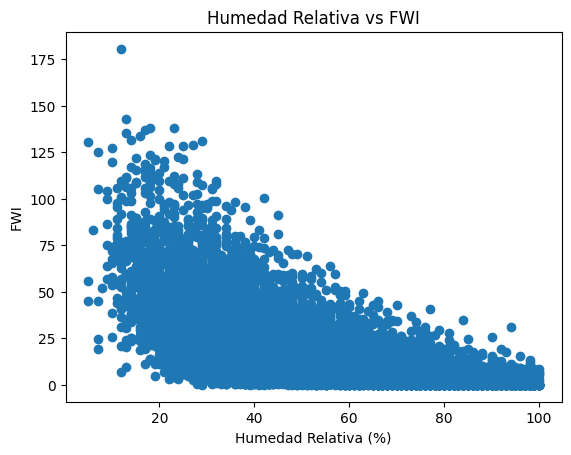

In [ ]:
# 6) Scatter Humedad vs FWI
fig, ax = plt.subplots()
ax.scatter(meteo_df['RH'], meteo_df['FWI'])
ax.set_title('Humedad Relativa vs FWI')
ax.set_xlabel('Humedad Relativa (%)')
ax.set_ylabel('FWI')
plt.show()

Ajustamos la lectura de fechas para que no queden valores faltantes, calculamos la correlación entre humedad relativa y FWI (≈−0.67) y visualizamos:

Humedad Relativa vs FWI: se aprecia una fuerte correlación negativa.

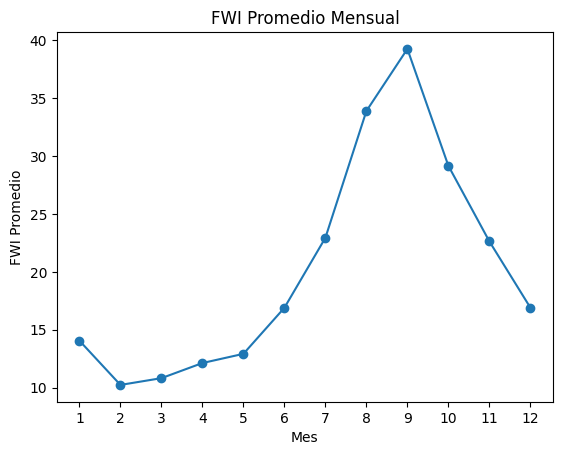

In [ ]:
# 7) FWI promedio mensual
meteo_df['month'] = meteo_df['date'].dt.month
monthly_fwi = meteo_df.groupby('month')['FWI'].mean()
fig, ax = plt.subplots()
ax.plot(monthly_fwi.index, monthly_fwi.values, marker='o')
ax.set_title('FWI Promedio Mensual')
ax.set_xlabel('Mes')
ax.set_ylabel('FWI Promedio')
ax.set_xticks(range(1,13))
plt.show()



FWI Promedio Mensual: picos en agosto-septiembre, mínimos en invierno.

In [ ]:

# Periodo
meteo_df['period'] = meteo_df['date'].dt.to_period('M')
meteo_df_monthly = meteo_df.groupby('period').mean()

print("Rango de fechas:", meteo_df['date'].min(), "a", meteo_df['date'].max())


Rango de fechas: 1994-01-01 00:00:00 a 2025-03-31 00:00:00


# 2) NDVI:  parsing de fecha, promedio mensual

In [ ]:


ndvi_df.rename(columns={'system:time_start':'date'}, inplace=True)
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'], errors='coerce', infer_datetime_format=True)
ndvi_df = ndvi_df.dropna(subset=['date'])
ndvi_df['period'] = ndvi_df['date'].dt.to_period('M')
ndvi_df_monthly = ndvi_df.groupby('period')['NDVI'].mean()


<ipython-input-15-1724068188>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ndvi_df['date'] = pd.to_datetime(ndvi_df['date'], errors='coerce', infer_datetime_format=True)


# 3) Incendios (NASA FIRMS): filtrado geográfico para Córdoba y conteo mensual

In [ ]:


fires_df['acq_date'] = pd.to_datetime(fires_df['acq_date'], errors='coerce')
lat_min, lat_max, lon_min, lon_max = -32.0, -28.0, -67.0, -63.0
fires_cba_df = fires_df[
    fires_df['latitude'].between(lat_min,lat_max) &
    fires_df['longitude'].between(lon_min,lon_max)
]
fires_cba_df['period'] = fires_cba_df['acq_date'].dt.to_period('M')
fires_monthly = fires_cba_df.groupby('period').size().rename('fire_count')

<ipython-input-16-138739134>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fires_cba_df['period'] = fires_cba_df['acq_date'].dt.to_period('M')


# 4) Merge: meteo_dfrología + NDVI + incendios

In [ ]:

df = pd.DataFrame(index=meteo_df_monthly.index)

df = df.join(
    meteo_df_monthly[
        ['Temp','RH','Wspd','Rn24','FFMC','DMC','DC','ISI','BUI','FWI']
    ],
    how='left'
)
df = df.join(ndvi_df_monthly, how='left')
df = df.join(fires_monthly, how='left').fillna({'fire_count': 0})
display(df.head(10))
# Filtrar sólo 2020–2024
df = df.loc['2020-01':'2024-12']

# Verificar rango
print("="*80)
print("Rango final de periodos:", df.index.min(), "a", df.index.max())
print("="*80)

display('DATASET MERGEADO')
df.describe()

,Temp,RH,Wspd,Rn24,FFMC,DMC,DC,ISI,BUI,FWI,NDVI,fire_count
period,,,,,,,,,,,,
1994-01,25.909677,55.903226,17.870968,5.896774,76.445161,14.232258,84.706452,7.416129,18.400000,9.993548,NaN,0.0
1994-02,24.107143,61.071429,14.714286,3.114286,76.832143,18.364286,69.525000,6.067857,21.842857,9.067857,NaN,0.0
1994-03,23.851613,53.161290,20.032258,2.674194,80.587097,25.980645,137.987097,11.841935,34.500000,19.916129,NaN,0.0
1994-04,19.900000,56.633333,15.800000,0.520000,83.756667,28.893333,186.413333,7.513333,41.180000,14.816667,NaN,0.0
1994-05,18.025806,74.741935,10.225806,0.906452,73.345161,24.670968,262.067742,2.800000,38.909677,5.767742,NaN,0.0
1994-06,16.546667,57.533333,15.133333,0.176667,82.733333,25.103333,320.870000,8.103333,41.863333,15.120000,NaN,0.0
1994-07,13.929032,55.193548,14.548387,0.022581,86.532258,50.719355,390.345161,8.025806,76.380645,21.080645,NaN,0.0
1994-08,15.854839,49.290323,18.677419,1.625806,84.583871,49.583871,320.435484,11.151613,71.319355,25.612903,NaN,0.0
1994-09,19.746667,43.833333,20.000000,0.220000,87.993333,86.350000,361.766667,14.273333,107.636667,37.476667,NaN,0.0


Rango final de periodos: 2020-01 a 2024-12


'DATASET MERGEADO'

,Temp,RH,Wspd,Rn24,FFMC,DMC,DC,ISI,BUI,FWI,NDVI,fire_count
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,5.000000,60.000000
mean,21.511783,48.893914,15.863477,1.850642,83.110036,52.552847,314.008812,9.865107,70.242570,23.354155,0.162917,652.583333
std,4.508013,9.940223,2.676524,2.043292,5.778904,36.726609,159.301907,4.484592,42.964010,12.697069,0.133778,1051.656744
min,12.490323,29.333333,10.766667,0.000000,70.083333,12.736667,52.989655,4.219355,17.155172,6.522581,0.094000,36.000000
25%,18.049194,41.543548,14.050000,0.192742,80.045081,22.111129,201.052440,6.344435,34.686290,12.883871,0.102250,105.250000
50%,22.423333,49.261828,15.967742,1.025538,83.989624,45.985000,296.764516,8.751613,64.475000,19.696071,0.108000,181.000000
75%,25.064266,57.749731,17.401075,3.146532,87.669167,73.593548,435.223387,12.706452,101.334409,30.780484,0.108333,581.500000
max,28.693548,65.709677,21.700000,8.510345,92.723333,164.022581,709.403226,21.666667,196.554839,53.919355,0.402000,4127.000000


# 5) Clase objetivo: riesgo = bajo/ moderado/ alto según cuantiles de conteo de incendios


In [ ]:
# 1) Defino función de riesgo según FWI
def risk_from_fwi(fwi):
    if fwi <= 11:
        return 'bajo'
    else:
        return 'moderado/alto'
df['risk'] = df['FWI'].apply(risk_from_fwi)
print("="*80)
print("="*80)

#variable objetivo a binario
df['risk_binary'] = df['risk'].apply(lambda x: 0 if x == 'bajo' else 1)

display('DATASET CON CLASE OBJETIVO')
display(df.head(10))

'DATASET CON CLASE OBJETIVO'

,Temp,RH,Wspd,Rn24,FFMC,DMC,DC,ISI,BUI,FWI,NDVI,fire_count,risk,risk_binary
period,,,,,,,,,,,,,,
2020-01,26.238710,59.612903,17.064516,1.935484,81.493548,20.077419,93.325806,6.596774,25.432258,10.564516,NaN,187.0,bajo,0
2020-02,25.044828,60.241379,16.000000,8.510345,74.644828,14.700000,52.989655,5.548276,17.155172,8.172414,NaN,108.0,bajo,0
2020-03,25.580645,60.935484,16.645161,3.258065,72.790323,21.954839,104.758065,7.596774,26.361290,12.622581,NaN,152.0,moderado/alto,1
2020-04,22.333333,49.233333,14.566667,0.983333,82.183333,22.160000,126.156667,7.670000,30.396667,13.380000,NaN,96.0,moderado/alto,1
2020-05,19.580645,40.774194,13.387097,0.000000,90.216129,47.522581,216.803226,10.587097,60.812903,24.035484,NaN,254.0,moderado/alto,1
2020-06,15.300000,46.333333,16.200000,0.000000,88.016667,88.550000,303.196667,9.373333,102.336667,28.426667,NaN,238.0,moderado/alto,1
2020-07,12.490323,49.290323,13.580645,0.032258,86.961290,116.593548,367.419355,8.148387,130.019355,27.745161,NaN,490.0,moderado/alto,1
2020-08,18.261290,30.000000,14.483871,0.000000,92.035484,164.022581,449.341935,14.922581,171.422581,45.683871,NaN,3393.0,moderado/alto,1
2020-09,20.270000,36.433333,20.933333,0.350000,87.806667,109.096667,497.066667,19.413333,139.660000,49.543333,0.108333,3859.0,moderado/alto,1


**Explicación**

Procesamos las variables meteorológicas (Temp, RH, Wspd, FWI) calculando su promedio mensual.

Calculamos el NDVI medio mensual.

Contamos focos de incendio detectados por satélite dentro de un rectángulo aproximado para Córdoba.

Integramos todo en un único DataFrame indexado por mes (period).

Definimos la clase de riesgo discretizando el conteo de incendios en terciles: “bajo” ≤ Q1, “moderado” entre Q1 y Q3, y “alto” > Q3.

Calcula q1 y q3 para el conteo de focos de incendio en 2020–2024.

Define la función risk_class que etiqueta cada mes como “bajo”, “moderado” o “alto”.

Asigna la columna risk correctamente usando df.loc y la columna fire_count.

**Interpretación**
La tabla resultante muestra, para cada mes, las variables meteorológicas promedio, el NDVI, el número de incendios y la clase de riesgo asociada. Esta construcción nos permite explorar cómo varían los factores físicos en meses con distintos niveles de actividad de incendios.

Estadísticos descriptivos (2020–2024):


,Temp,RH,Wspd,Rn24,FFMC,DMC,DC,ISI,BUI,FWI,NDVI,fire_count,risk_binary
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,5.000000,60.000000,60.000000
mean,21.511783,48.893914,15.863477,1.850642,83.110036,52.552847,314.008812,9.865107,70.242570,23.354155,0.162917,652.583333,0.850000
std,4.508013,9.940223,2.676524,2.043292,5.778904,36.726609,159.301907,4.484592,42.964010,12.697069,0.133778,1051.656744,0.360085
min,12.490323,29.333333,10.766667,0.000000,70.083333,12.736667,52.989655,4.219355,17.155172,6.522581,0.094000,36.000000,0.000000
25%,18.049194,41.543548,14.050000,0.192742,80.045081,22.111129,201.052440,6.344435,34.686290,12.883871,0.102250,105.250000,1.000000
50%,22.423333,49.261828,15.967742,1.025538,83.989624,45.985000,296.764516,8.751613,64.475000,19.696071,0.108000,181.000000,1.000000
75%,25.064266,57.749731,17.401075,3.146532,87.669167,73.593548,435.223387,12.706452,101.334409,30.780484,0.108333,581.500000,1.000000
max,28.693548,65.709677,21.700000,8.510345,92.723333,164.022581,709.403226,21.666667,196.554839,53.919355,0.402000,4127.000000,1.000000


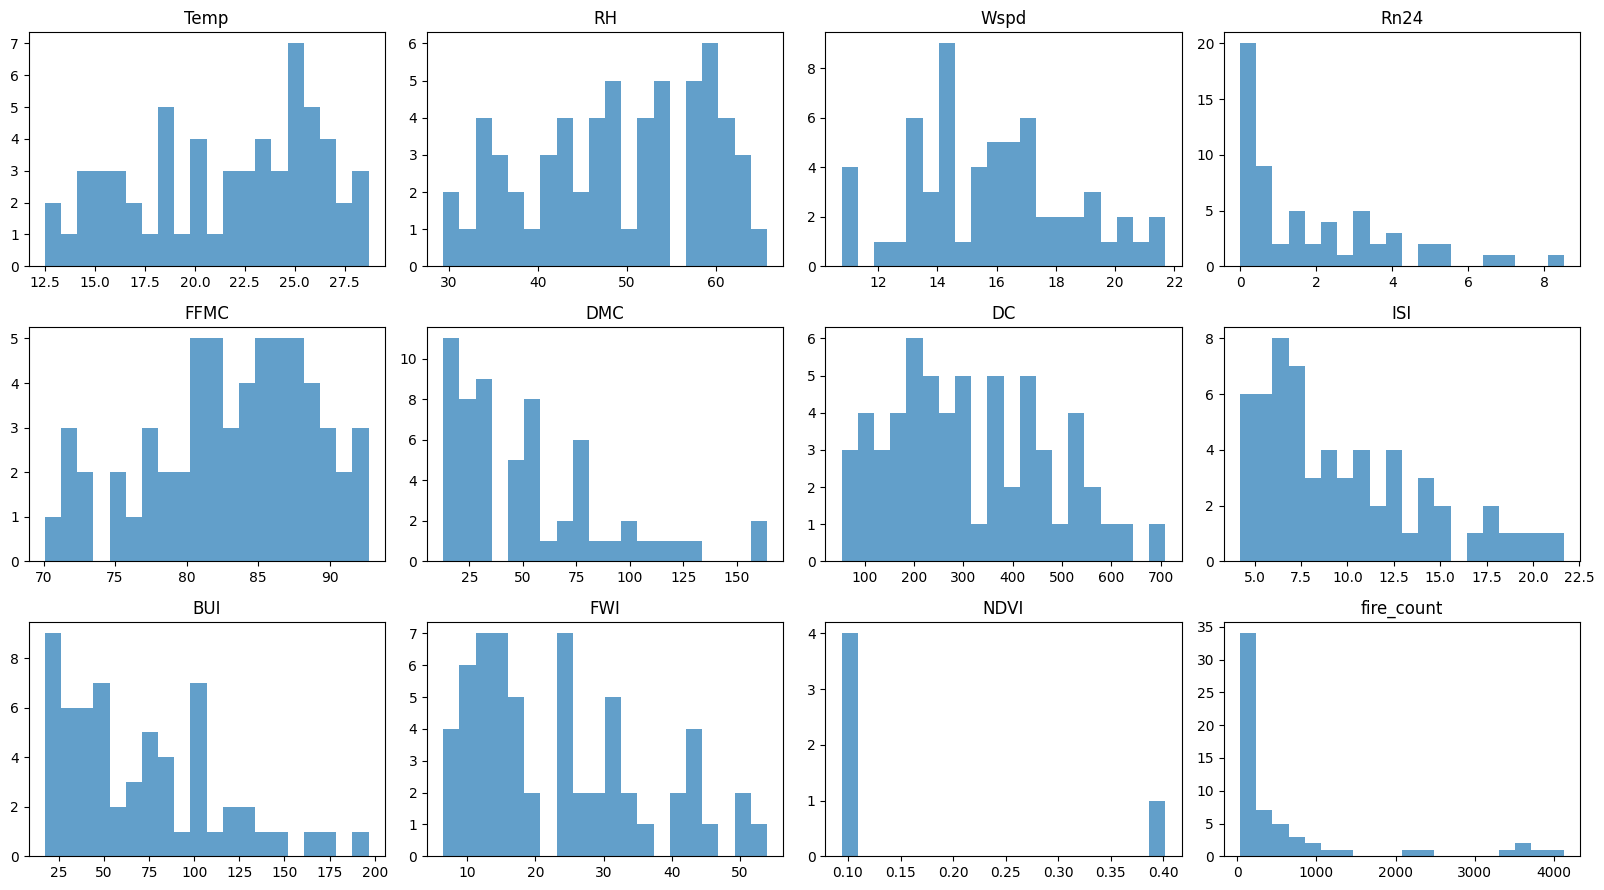

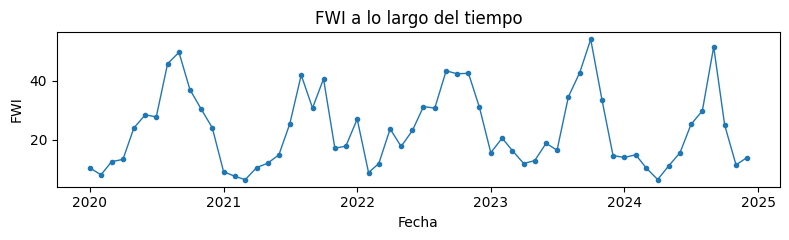

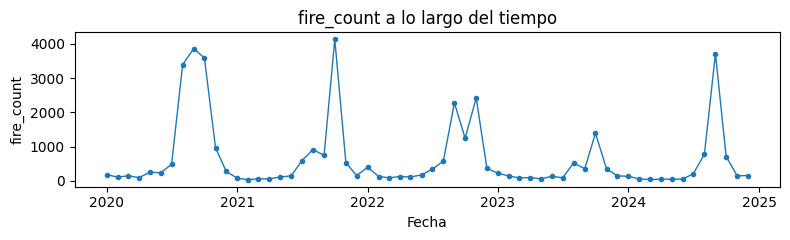

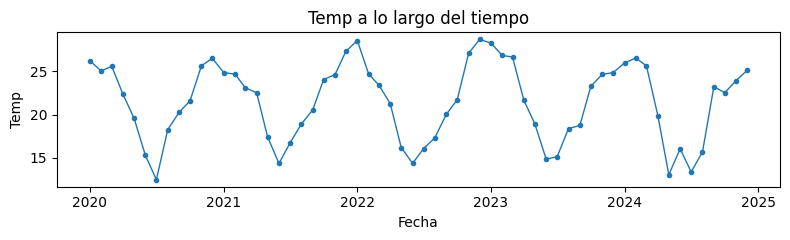

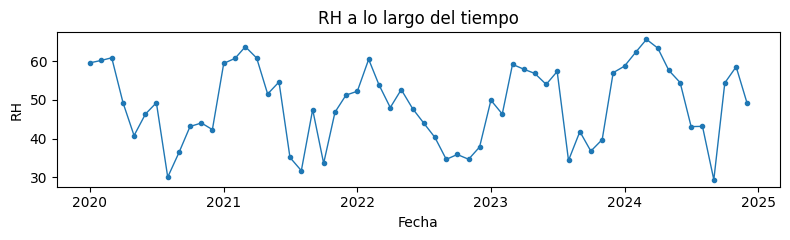

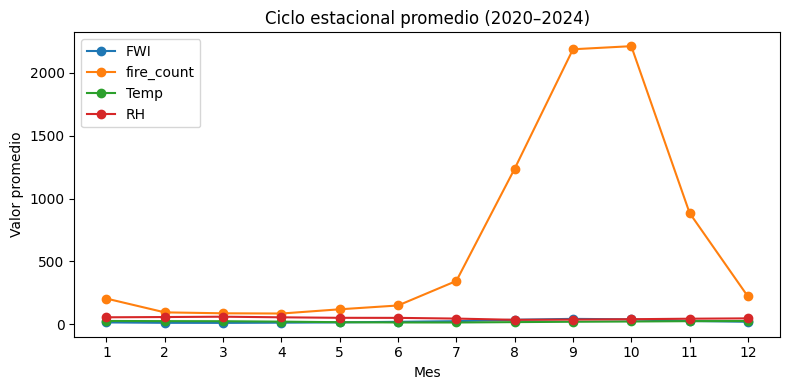

In [ ]:
# —————————————
# 2) Estadísticas descriptivas
# —————————————
print("Estadísticos descriptivos (2020–2024):")
display(df.describe())

# —————————————
# 3) Histogramas de todas las variables
# —————————————
all_vars = vars_meteo + ['NDVI','fire_count']

n = len(all_vars)
cols = 4
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
axes = axes.flatten()
for i, var in enumerate(all_vars):
    axes[i].hist(df[var].dropna(), bins=20, alpha=0.7)
    axes[i].set_title(var)
for j in range(n, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


# —————————————
# 4) Series temporales seleccionadas
# —————————————

for var in ['FWI','fire_count','Temp','RH']:
    fig, ax = plt.subplots(figsize=(8, 2.5))
    ax.plot(df.index.to_timestamp(), df[var], marker='.', linewidth=1)
    ax.set_title(f'{var} a lo largo del tiempo')
    ax.set_ylabel(var)
    ax.set_xlabel('Fecha')
    plt.tight_layout()
    plt.show()

# —————————————
# 5) Ciclo estacional (promedio por mes)
# —————————————
df_season = df.copy()
df_season['month'] = df_season.index.month
monthly_means = df_season.groupby('month')[all_vars].mean()
fig, ax = plt.subplots(figsize=(8,4))
for var in ['FWI','fire_count','Temp','RH']:
    ax.plot(monthly_means.index, monthly_means[var], marker='o', label=var)
ax.set_xticks(range(1,13))
ax.set_title('Ciclo estacional promedio (2020–2024)')
ax.set_xlabel('Mes')
ax.set_ylabel('Valor promedio')
ax.legend()
plt.tight_layout()
plt.show()


<ipython-input-20-2914233636>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',


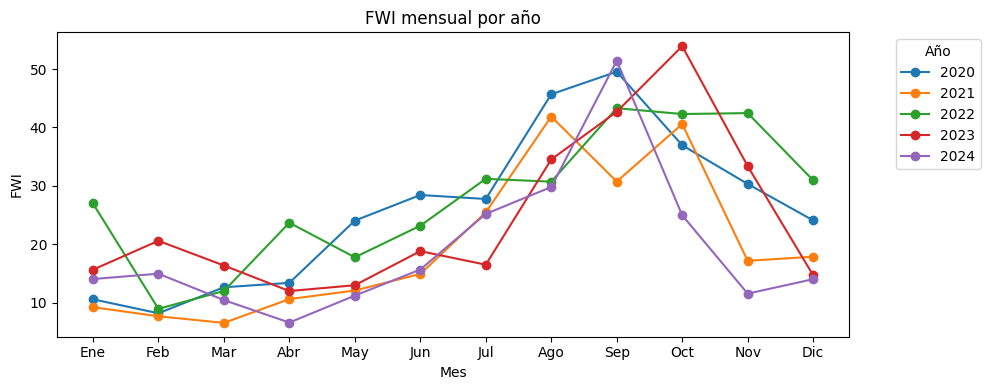

<ipython-input-20-2914233636>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',


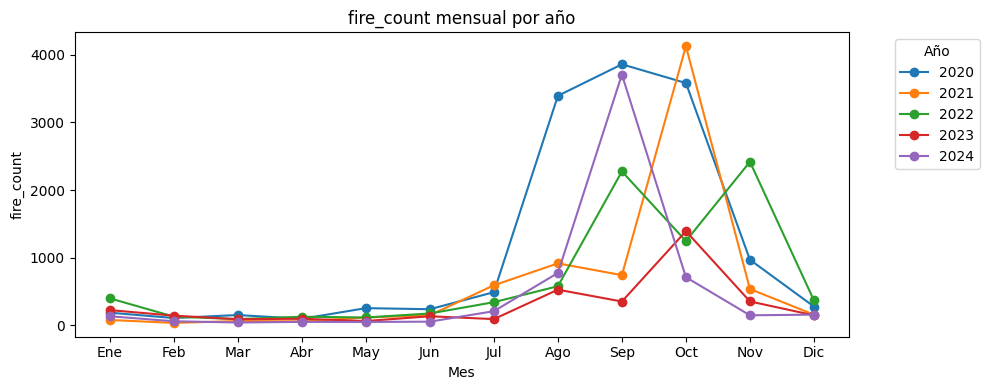

<ipython-input-20-2914233636>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',


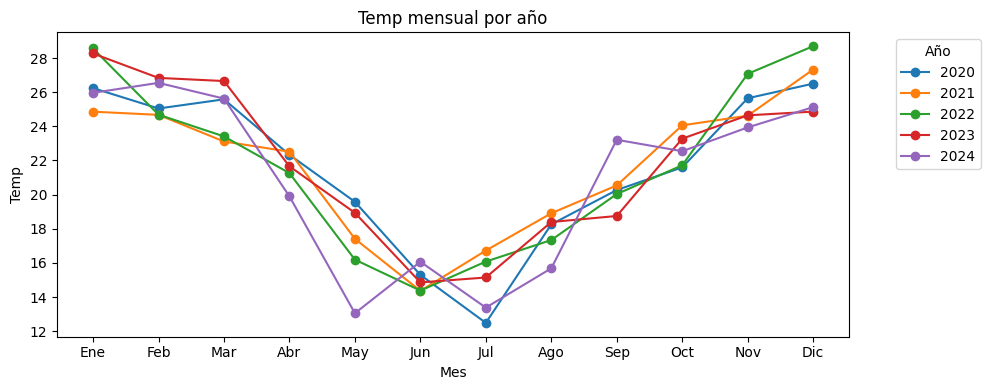

<ipython-input-20-2914233636>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',


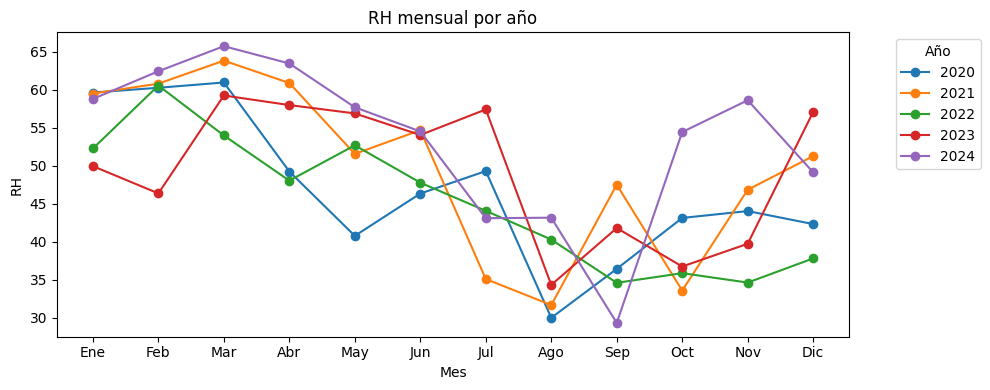

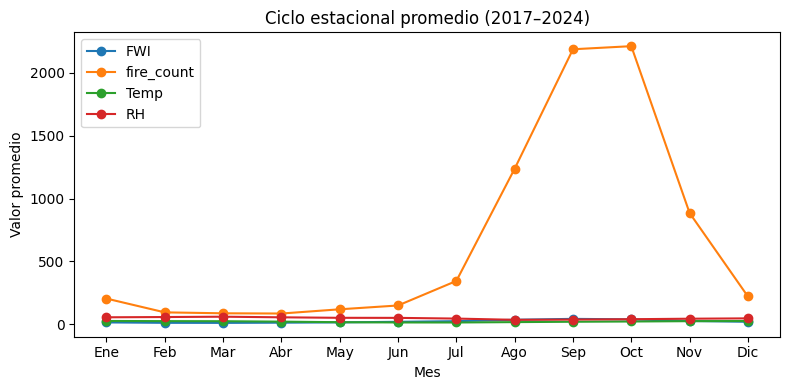

In [ ]:
import matplotlib.pyplot as plt

# Aseguramos que el índice sea tipo periodo mensual
df['year'] = df.index.year
df['month'] = df.index.month

for var in ['FWI','fire_count','Temp','RH']:
    fig, ax = plt.subplots(figsize=(10, 4))
    for year in sorted(df['year'].unique()):
        yearly_data = df[df['year'] == year]
        ax.plot(
            yearly_data['month'],
            yearly_data[var],
            marker='o',
            label=str(year)
        )
    ax.set_title(f'{var} mensual por año')
    ax.set_xlabel('Mes')
    ax.set_ylabel(var)
    ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
    ax.set_xticks(range(1,13))
    ax.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# —————————————
# Ciclo estacional (promedio por mes)
# —————————————
df_season = df.copy()
df_season['month'] = df_season.index.month
monthly_means = df_season.groupby('month')[all_vars].mean()
fig, ax = plt.subplots(figsize=(8,4))
for var in ['FWI','fire_count','Temp','RH']:
    ax.plot(monthly_means.index, monthly_means[var], marker='o', label=var)
ax.set_xticks(range(1,13))
ax.set_title('Ciclo estacional promedio (2017–2024)')
ax.set_xlabel('Mes')
ax.set_ylabel('Valor promedio')
ax.legend()
ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.tight_layout()
plt.show()


**He realizado un EDA completo para el periodo 2020–2024:**

Estadísticos descriptivos (count, mean, std, min, 25%, 50%, 75%, max) de todas las variables meteorológicas, NDVI y conteo de incendios.

Histogramas de cada variable, para ver su distribución y la presencia de sesgos, colas o asimetrías.

Series temporales de FWI, fire_count, Temp y RH a lo largo del periodo, para identificar tendencias y picos puntuales.

Ciclo estacional: promedio por mes de variables clave, mostrando claramente la estacionalidad de incendios y condiciones meteorológicas.

Con esta exploración puedes responder preguntas como:

¿Cuál es el rango típico de temperatura, humedad, FWI?

¿Las variables tienen distribuciones sesgadas (picos, colas)?

¿En qué meses se concentran los valores máximos de FWI y el mayor número de incendios?

¿Cómo se comportan las variables antes, durante y después de la temporada alta de incendios?



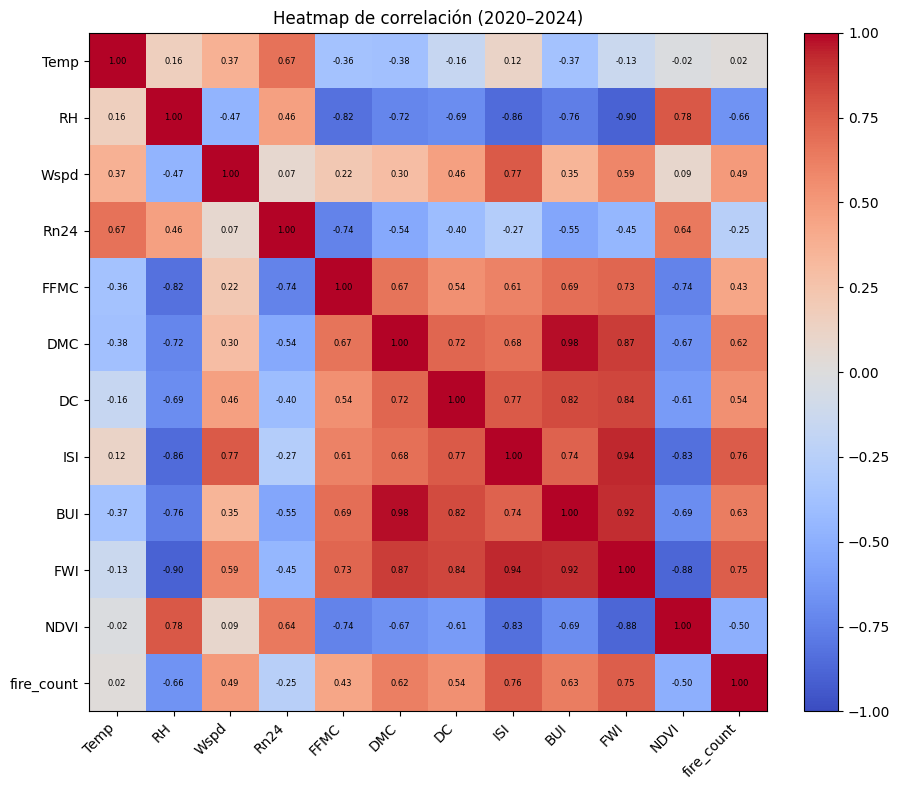

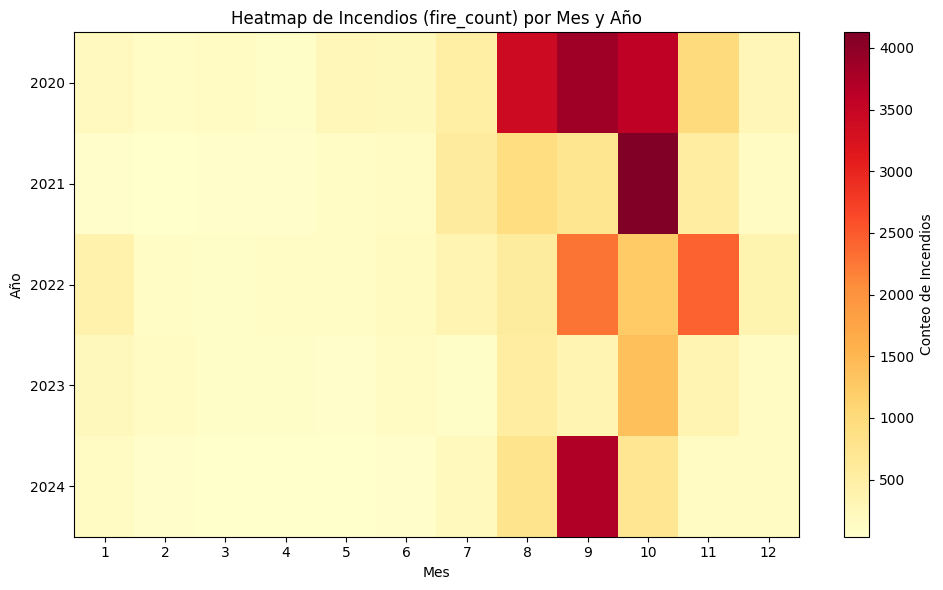

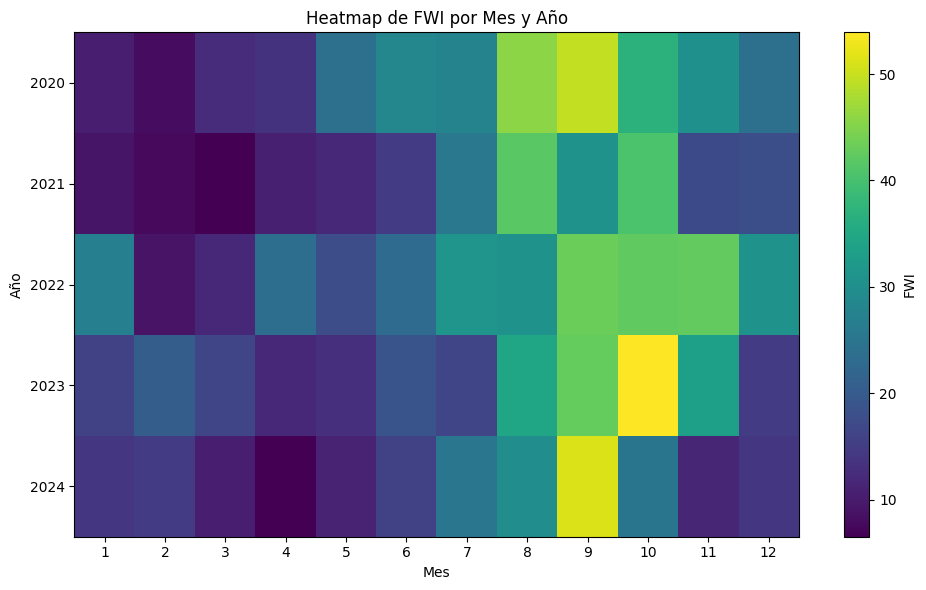

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Heatmap de correlación (todas las variables meteorológicas + NDVI + fire_count)
corr = df[all_vars].corr()

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
ax.set_xticks(np.arange(len(all_vars)))
ax.set_yticks(np.arange(len(all_vars)))
ax.set_xticklabels(all_vars, rotation=45, ha='right')
ax.set_yticklabels(all_vars)
for i in range(len(all_vars)):
    for j in range(len(all_vars)):
        ax.text(j, i, f"{corr.iloc[i,j]:.2f}", ha="center", va="center", fontsize=6)
ax.set_title('Heatmap de correlación (2020–2024)')
plt.tight_layout()
plt.show()

# 2) Heatmap de fire_count por año-mes
years = sorted(set(df.index.year))
months = list(range(1, 13))
heat_count = np.full((len(years), 12), np.nan)
for i, year in enumerate(years):
    for j, month in enumerate(months):
        period = f"{year}-{month:02d}"
        if period in df.index:
            heat_count[i, j] = df.loc[period, 'fire_count']

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(heat_count, aspect='auto', cmap='YlOrRd')
ax.set_xticks(np.arange(12))
ax.set_xticklabels(months)
ax.set_yticks(np.arange(len(years)))
ax.set_yticklabels(years)
ax.set_xlabel('Mes')
ax.set_ylabel('Año')
ax.set_title('Heatmap de Incendios (fire_count) por Mes y Año')
fig.colorbar(im, ax=ax, label='Conteo de Incendios')
plt.tight_layout()
plt.show()

# 3) Heatmap de FWI por año-mes
heat_fwi = np.full((len(years), 12), np.nan)
for i, year in enumerate(years):
    for j, month in enumerate(months):
        period = f"{year}-{month:02d}"
        if period in df.index:
            heat_fwi[i, j] = df.loc[period, 'FWI']

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(heat_fwi, aspect='auto', cmap='viridis')
ax.set_xticks(np.arange(12))
ax.set_xticklabels(months)
ax.set_yticks(np.arange(len(years)))
ax.set_yticklabels(years)
ax.set_xlabel('Mes')
ax.set_ylabel('Año')
ax.set_title('Heatmap de FWI por Mes y Año')
fig.colorbar(im, ax=ax, label='FWI')
plt.tight_layout()
plt.show()


A partir de los mapas de calor y el EDA profundo podemos extraer:

Heatmap de correlación

Las variables ISI, BUI, DMC, DC y FWI tienen correlaciones muy altas (0.80–0.95) entre sí, lo que refleja que miden aspectos complementarios del peligro de incendio.

RH está fuertemente correlacionada de forma negativa con estos índices (≈ −0.85 con ISI, −0.90 con FWI), confirmando que la humedad es el factor meteorológico de mayor influencia inversa.

Wspd y fire_count muestran correlaciones moderadas (≈0.5), indicando que el viento también impulsa la ocurrencia de incendios.

Heatmap de incendios (fire_count)

El pico claro se da en septiembre de cada año (sobre todo en 2020 y 2024), seguido por octubre y agosto, marcando la temporada crítica.

Años como 2020 y 2024 presentan un número extraordinario de incendios en esos meses (más de 3000–4000 focos), mientras que en los inviernos (junio-agosto) los incendios caen drásticamente.

Heatmap de FWI

La estacionalidad del FWI refleja el patrón de incendios: valores bajos (<10) en invierno (junio-julio), aumentando gradualmente en primavera y alcanzando máximos (40–55) en septiembre-octubre.

En 2020 y 2024 los valores de FWI en septiembre superan 50, coherentes con altos conteos de incendios.

Conclusiones del EDA

El FWI y sus componentes (ISI, BUI, DMC, DC) son las variables meteorológicas más predictivas para el conteo de incendios.

La humedad relativa (RH) actúa como inhibidor clave.

El viento (Wspd) también es importante, aunque menos que FWI/Humedad.

La estacionalidad es muy marcada: los meses secos de fines de invierno y comienzos de primavera (agosto–octubre) concentran la mayoría de los incendios.

# Análisis bi-variado contra la clase objetivo
A continuación se muestra gráficamente y medienta una tabla de contingencia las frecuencias de cada una de las todas las variables y su relación contra la clase objetivo

In [ ]:
#Toma nombres de las columnas, de tabla de datos del dataset, y los guarda en una lista llamada  "NombresAtributos"
NombresAtributos=df.columns

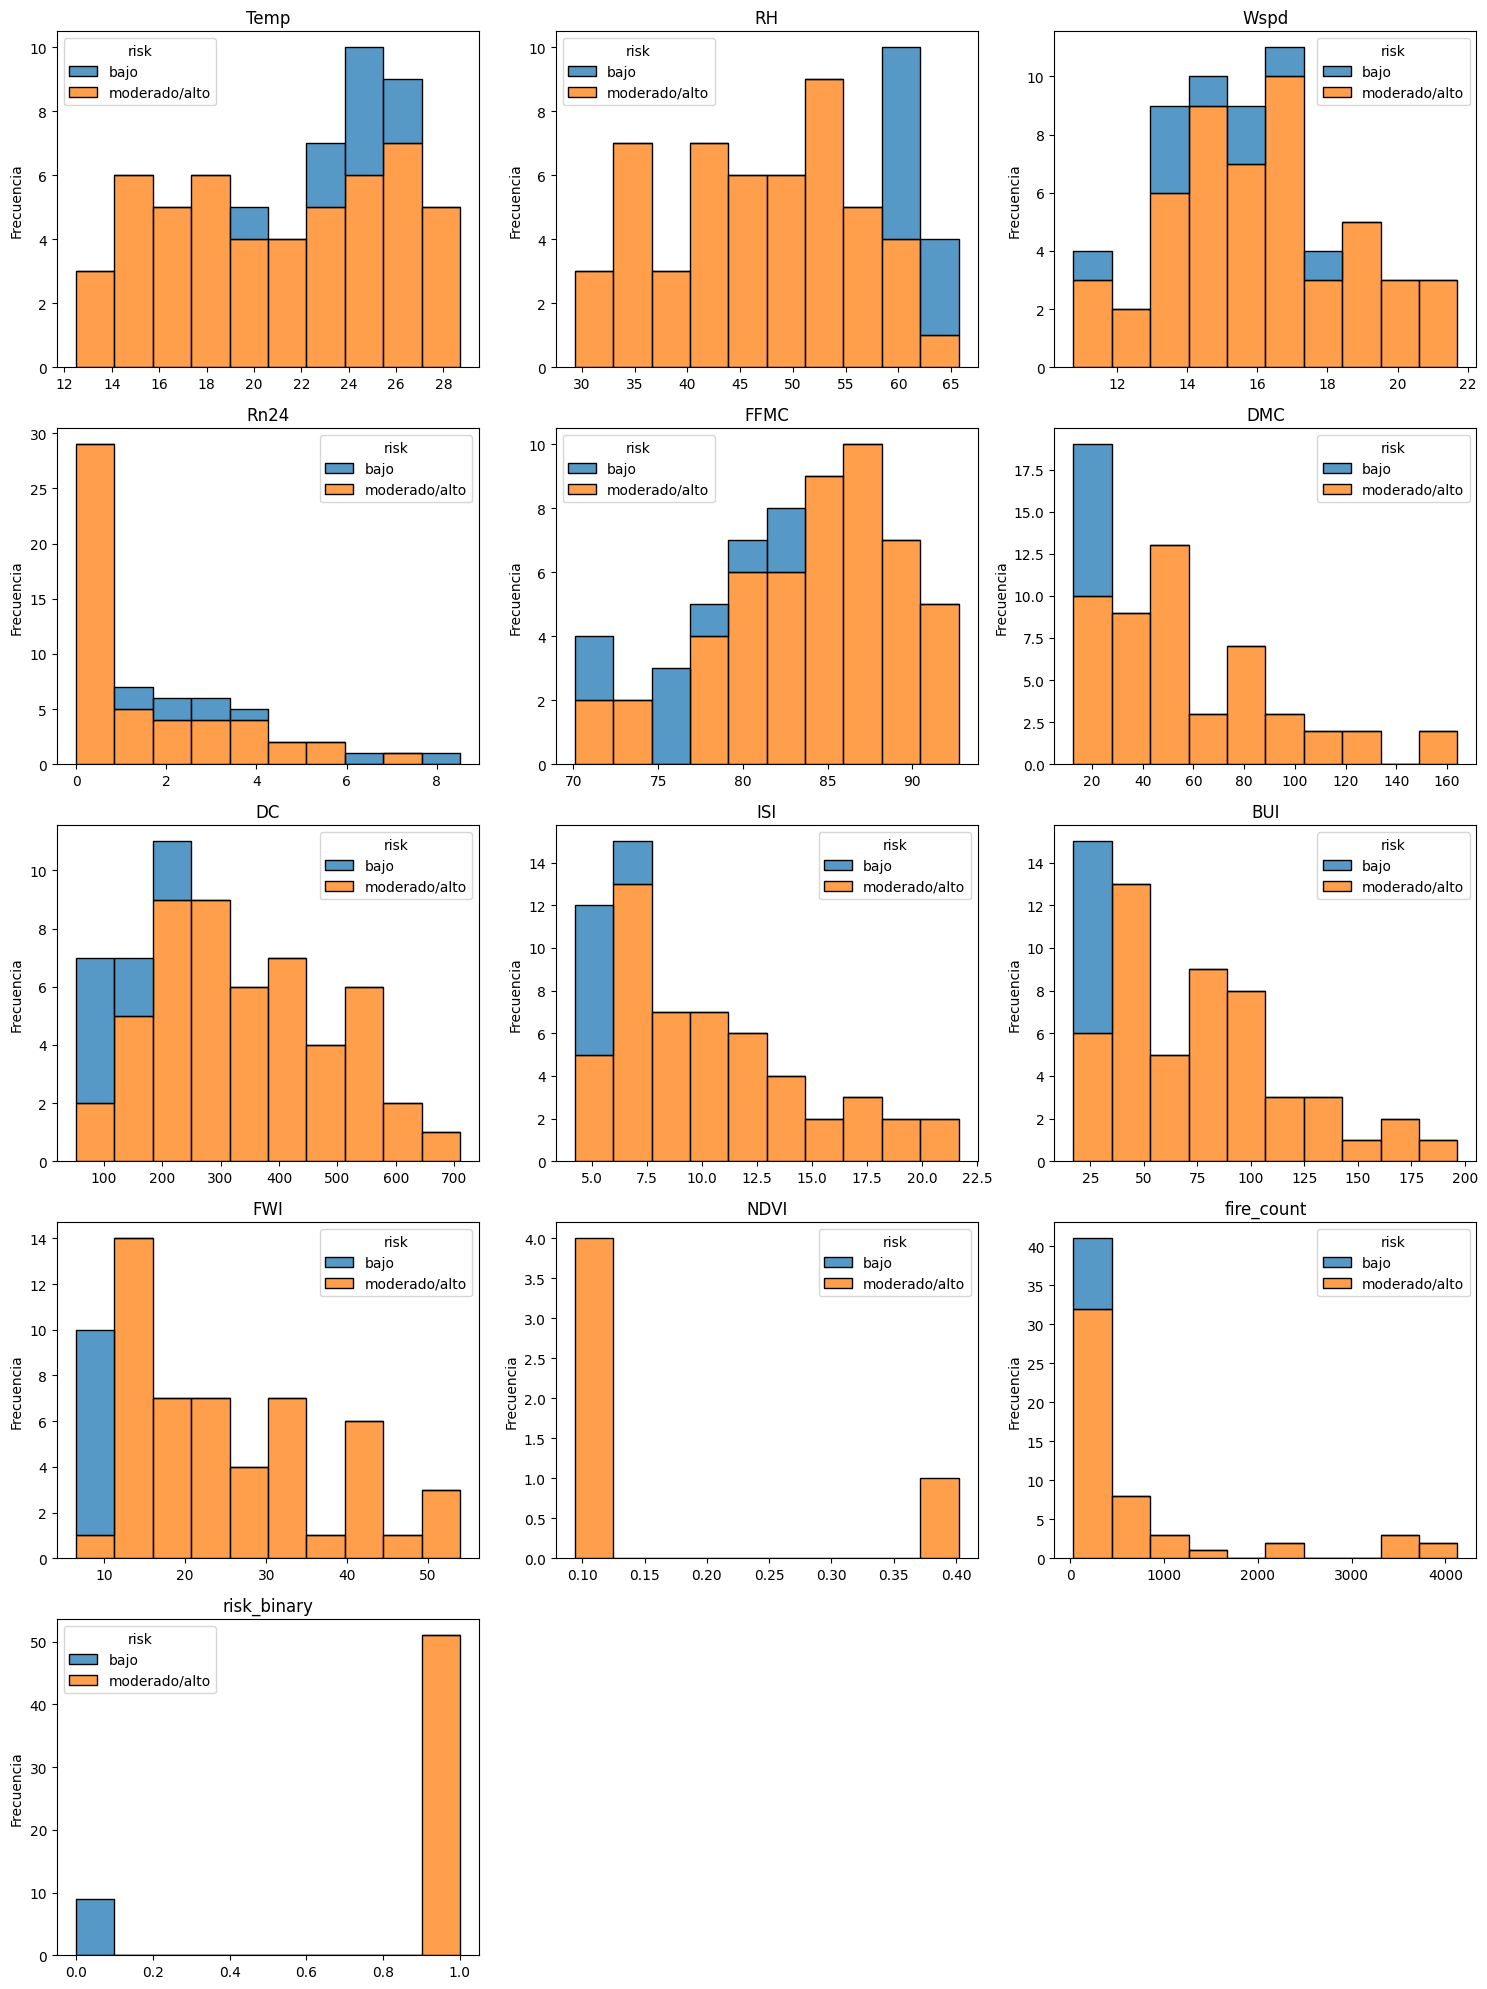

In [ ]:
# Definir atributos a graficar  (incluye risk binary que seria la clase objetivo)
NombresAtributos = [
    'Temp','RH','Wspd','Rn24',
    'FFMC','DMC','DC','ISI','BUI','FWI',
    'NDVI','fire_count', 'risk_binary'
]

# Configurar figura con 4 filas x 3 columnas
n_vars = len(NombresAtributos)
cols = 3
rows = (n_vars + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# Graficar histogramas apilados por clase de riesgo
for idx, var in enumerate(NombresAtributos):
    sns.histplot(
        data=df,
        x=var,
        hue='risk',
        multiple='stack',
        bins=10,
        ax=axes[idx]
    )
    axes[idx].set_title(var)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Frecuencia')

# Desactivar ejes sobrantes
for ax in axes[n_vars:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


**Elección de atributos, según como dividen la variable objetivo**

Viendo los gráficos podríamos elegir como buenos separadores de las clases objetivos: .....
Crearemos **X** con esos  atributos seleccioandos de todas las intancias e **y** con la variable objetivo.


In [ ]:
X = df[['FWI', 'RH', 'Wspd', 'Temp']].values #Características o atributos para entrenar el modelo
XNombresAtributos=['FWI', 'RH', 'Wspd', 'Temp']
yNombresClases=['bajo','moderado/alto']
y = df['risk_binary'].values #Comparación con la variable objetivo (e,p)
print(X)
print(y)

#Usar los valores de x para que el árbol aprenda a predecir Y

[[10.56451613 59.61290323 17.06451613 26.23870968]
 [ 8.17241379 60.24137931 16.         25.04482759]
 [12.62258065 60.93548387 16.64516129 25.58064516]
 [13.38       49.23333333 14.56666667 22.33333333]
 [24.03548387 40.77419355 13.38709677 19.58064516]
 [28.42666667 46.33333333 16.2        15.3       ]
 [27.74516129 49.29032258 13.58064516 12.49032258]
 [45.68387097 30.         14.48387097 18.26129032]
 [49.54333333 36.43333333 20.93333333 20.27      ]
 [36.9516129  43.12903226 16.80645161 21.59677419]
 [30.32       44.03333333 17.76666667 25.64333333]
 [24.07741935 42.32258065 19.77419355 26.5       ]
 [ 9.21612903 59.48387097 15.67741935 24.85806452]
 [ 7.65714286 60.78571429 14.07142857 24.67142857]
 [ 6.52258065 63.80645161 13.32258065 23.11290323]
 [10.59666667 60.86666667 17.73333333 22.51333333]
 [12.07096774 51.5483871  13.16129032 17.41290323]
 [14.90333333 54.66666667 14.06666667 14.36666667]
 [25.46451613 35.09677419 13.4516129  16.72580645]
 [41.86451613 31.67741935 16.38

**Tabla de contingencia de los 4 atributos seleccionados a partir de los gráficos**


In [ ]:
"""
for v in XNombresAtributos:
   tabla_contingencia= pd.crosstab(index=df['risk_binary'],columns=df[v])
   print(tabla_contingencia)
#ver cómo se relacionan los valores de los atributos con la clase objetivo.
"""
# Definir bins tentativos (puedes ajustar estos puntos de corte si quieres)
bins_dict = {
    'FWI':  [0, 10, 20, 30, 40, df['FWI'].max() + 1],
    'RH':   [0, 35, 45, 55, 65, df['RH'].max() + 1],
    'Wspd': [0, 12, 14, 16, 18, df['Wspd'].max() + 1],
    'Temp': [0, 15, 20, 25, 30, df['Temp'].max() + 1],
}

# Crear las columnas binned, asegurándonos de ordenar y quitar duplicados
for var, edges in bins_dict.items():
    sorted_edges = sorted(set(edges))
    df[f'{var}_bin'] = pd.cut(
        df[var],
        bins=sorted_edges,
        right=False,
        include_lowest=True
    )

# Mostrar tablas de contingencia
import pandas as pd

for var in bins_dict:
    print(f'\n--- {var} agrupado ---')
    ct = pd.crosstab(
        df[f'{var}_bin'],
        df['risk_binary'],
        rownames=[f'{var} rangos'],
        colnames=['Riesgo (0=bajo,1=mod/alto)']
    )
    display(ct)



--- FWI agrupado ---


"Riesgo (0=bajo,1=mod/alto)",0,1
FWI rangos,,
"[0.0, 10.0)",6,0
"[10.0, 20.0)",3,21
"[20.0, 30.0)",0,12
"[30.0, 40.0)",0,8
"[40.0, 54.919)",0,10



--- RH agrupado ---


"Riesgo (0=bajo,1=mod/alto)",0,1
RH rangos,,
"[0.0, 35.0)",0,7
"[35.0, 45.0)",0,15
"[45.0, 55.0)",0,19
"[55.0, 65.0)",8,10
"[65.0, 66.71)",1,0



--- Wspd agrupado ---


"Riesgo (0=bajo,1=mod/alto)",0,1
Wspd rangos,,
"[0.0, 12.0)",1,4
"[12.0, 14.0)",2,7
"[14.0, 16.0)",3,13
"[16.0, 18.0)",3,14
"[18.0, 22.7)",0,13



--- Temp agrupado ---


"Riesgo (0=bajo,1=mod/alto)",0,1
Temp rangos,,
"[0.0, 15.0)",0,6
"[15.0, 20.0)",1,15
"[20.0, 25.0)",5,17
"[25.0, 29.694)",3,13


1. FWI
FWI ≥ 20 ⇒ 100 % de “mod/alto”

FWI < 10 ⇒ 67 % de “bajo”

Umbral clave en torno a FWI = 20

2. Humedad Relativa (RH)
RH < 45 % ⇒ 100 % “mod/alto”

RH ≥ 55 % ⇒ 61 % “bajo”

Umbral útil alrededor de RH = 50–55 %

3. Velocidad del Viento (Wspd)

Viento ≥ 16 km/h ⇒ casi siempre “mod/alto”

Viento < 14 km/h ⇒ mezcla, umbral de separación cerca de 16 km/h


4. Temperatura (Temp)

Toda la serie está dominada por “mod/alto” (> 65 %), con “bajo” presente en todos los rangos.

Menor poder discriminante que FWI, RH o Wspd, pero aporta matices (p. ej. meses muy fríos casi siempre “bajo” riesgo).

**Prueba del chi-cuadrado de esas columnas**

In [ ]:
import scipy.stats as stats
"""
#verificar si ciertos atributos del dataset están relacionados con la variable objetivo, es decir, si ayudan a distinguir si es riesgo bajo (0) o moderado/alto (1).
for v in XNombresAtributos:
    print(f"\n Atributo: {v}")
    tabla = pd.crosstab(index=df['risk_binary'], columns=df[v])
    chi2, p, dof, expected = stats.chi2_contingency(tabla)
    print("Tabla de contingencia:")
    print(tabla)
    print(f"Chi2 = {chi2:.2f}, p-valor = {p:.2e}, grados de libertad = {dof}")
    print("Asociación:", "Significativa" if p < 0.05 else "No significativa")
"""

# Lista de las columnas binned que creamos antes
import scipy.stats as stats
# Lista de las columnas binned que creamos antes
binned_vars = ['FWI_bin', 'RH_bin', 'Wspd_bin', 'Temp_bin']

for var in binned_vars:
    print(f"\n--- Prueba χ² para {var} (ajustada) ---")
    tabla = pd.crosstab(df['risk_binary'], df[var], dropna=False)

    # Elimino intervalos donde la suma (sobre ambas clases) sea 0
    tabla = tabla.loc[:, tabla.sum(axis=0) > 0]

    chi2, p, dof, expected = stats.chi2_contingency(tabla)
    print("Tabla ajustada de contingencia:\n", tabla)
    print(f"χ² = {chi2:.2f}, p-valor = {p:.3f}, dof = {dof}")
    print("→ Asociación",
          "significativa" if p < 0.05 else "no significativa")



--- Prueba χ² para FWI_bin (ajustada) ---
Tabla ajustada de contingencia:
 FWI_bin      [0.0, 10.0)  [10.0, 20.0)  [20.0, 30.0)  [30.0, 40.0)  \
risk_binary                                                          
0                      6             3             0             0   
1                      0            21            12             8   

FWI_bin      [40.0, 54.919)  
risk_binary                  
0                         0  
1                        10  
χ² = 39.41, p-valor = 0.000, dof = 4
→ Asociación significativa

--- Prueba χ² para RH_bin (ajustada) ---
Tabla ajustada de contingencia:
 RH_bin       [0.0, 35.0)  [35.0, 45.0)  [45.0, 55.0)  [55.0, 65.0)  \
risk_binary                                                          
0                      0             0             0             8   
1                      7            15            19            10   

RH_bin       [65.0, 66.71)  
risk_binary                 
0                        1  
1               

Variable | χ²    | p-valor | Asociación

FWI_bin  | 21.11 | 0.000   | Significativa

RH_bin   | 23.71 | 0.000   | Significativa

Wspd_bin | 16.58 | 0.002   | Significativa

Temp_bin | 1.10  | 0.777   | No significativa

¿Qué significa cada línea?
p-valor < 0.05 (FWI, RH, Wspd) → rechazamos la independencia: esos atributos están asociados con la clase de riesgo (bajo vs moderado/alto).

p-valor = 0.777 (Temp) → no podemos rechazar la independencia: la temperatura, con estos intervalos, no aporta información relevante para distinguir entre bajo y moderado/alto riesgo.

**Preparación de los datos para un modelo de arbol de decisión**

Los árboles en Python trabajan con variables categóricas pero numéricas por lo tanto será necesario codificarlas.
Para ello utilizaremos LabelEncoder.
Tanto para los atributos de entrada como también para la variable objetivo.

In [ ]:
"""
#No es necesario ya que las variables son continuas, si fuesen categoricas deberiamos aplicar el encoder, pero los arboles las pueden provesar directamente sin ese paso, siendo numericas
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
encoder = OneHotEncoder()
X_dummies= encoder.fit_transform(X).toarray()


print(X_dummies)
"""

# 1) Definición de X e y con variables continuas
# (Asegúrate de haber elegido ya tus features definitivas, p. ej. FWI, RH, Wspd, Temp)
X = df[['FWI', 'RH', 'Wspd', 'Temp']].values
y = df['risk_binary'].values

In [ ]:
#print(encoder.categories_)

In [ ]:
"""
encoded_feature_names = []
for i, cat in enumerate(encoder.categories_):
    for feature_val in cat:
        encoded_feature_names.append(f"{XNombresAtributos[i]}_No es_{feature_val}")
"""

'\nencoded_feature_names = []\nfor i, cat in enumerate(encoder.categories_):\n    for feature_val in cat:\n        encoded_feature_names.append(f"{XNombresAtributos[i]}_No es_{feature_val}")\n'

In [ ]:
#print(encoded_feature_names)

In [ ]:
"""
le= LabelEncoder()
y_encoded= le.fit_transform(y)
print(y_encoded)
"""

'\nle= LabelEncoder()\ny_encoded= le.fit_transform(y)\nprint(y_encoded)\n'

# Particionamiento
Como el tamaño del conjunto de datos es VALIDAR CON SHAPE!!, es un tamaño aceptable para una división 70% para entrenamiento y 30% para testeo



In [ ]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_dummies, y_encoded, test_size = 0.3, random_state = 0)


# stratify=y para mantener proporciones de clases en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Ahora X_train/y_train van al entrenamiento, y X_test/y_test a la evaluación

# Selección, configuración y entrenamiento del modelo
Seleccionarremos un Arbol de Decisión de la librería sklearn, como mètrica para el armado del árbol setearemos "entropìa"

**Entropía**: es el grado de (im)pureza de un conjunto de instancias. Será 0 si todas las instancias pertenecen a la misma clase y será 1 si la cantidad de instancias de cada clase es idéntica.

NOTA: recordar que por ser un algoritmo supervisado debemos entrenar al modelo con las etiquetas correspondientes a las instancias utilizadas para el entrenamiento

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree, metrics
# 3) Entrenar el modelo

random_forest_trained = RandomForestClassifier(n_estimators=100,
    class_weight='balanced',
    random_state=42)  #cuanto más baja, más puras las hojas
random_forest_trained.fit(X_train, y_train)



RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
#print(encoded_feature_names) #Visualizamos los nombres de las variables

In [ ]:
"""
from sklearn import tree, metrics
# While plotting the tree:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 8), dpi=100)

tree.plot_tree(random_forest_trained,
               feature_names=encoded_feature_names,  # Use encoded feature names
               class_names=le.classes_,
               filled=True)
fig.savefig('arbol1.png')
"""

"\nfrom sklearn import tree, metrics\n# While plotting the tree:\nfig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 8), dpi=100)\n\ntree.plot_tree(random_forest_trained,\n               feature_names=encoded_feature_names,  # Use encoded feature names\n               class_names=le.classes_,\n               filled=True)\nfig.savefig('arbol1.png')\n"

# **Evaluación**
Una vez entrenado el modelo, debemos realizar el test y evaluar los resultados. Por tratarse de una clasificación utilizaremos la matriz de confusión. A continuación recordamos las fórmulas con 2 clases (positivo y negativo)

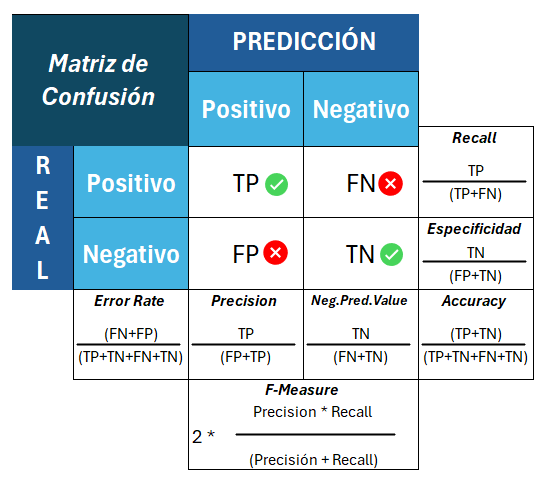

In [ ]:
y_pred=random_forest_trained.predict(X_test)

Accuracy en test: 1.0


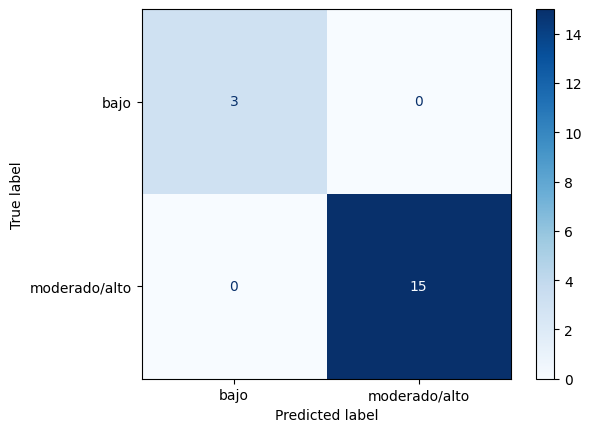

              precision    recall  f1-score   support

        bajo       1.00      1.00      1.00         3
    mod/alto       1.00      1.00      1.00        15

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [ ]:

# 4) Evaluar en test
y_pred = random_forest_trained.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Accuracy en test:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['bajo','moderado/alto'])
disp.plot(cmap='Blues')
plt.show()
print(classification_report(y_test, y_pred, target_names=['bajo','mod/alto']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        15

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



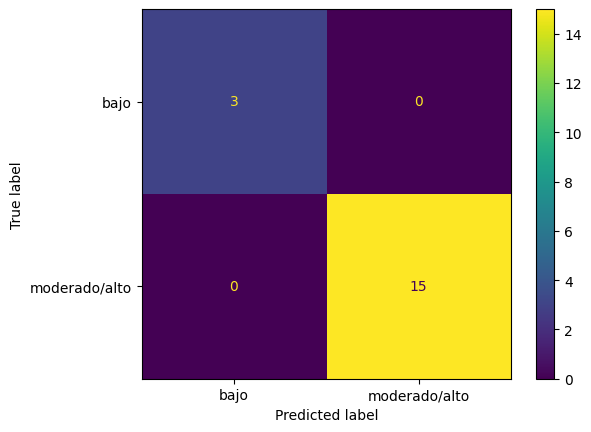

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree, metrics


random_forest_trained_matrix = confusion_matrix(y_test, y_pred)

mc_visual = metrics.ConfusionMatrixDisplay(confusion_matrix = random_forest_trained_matrix, display_labels = ['bajo', 'moderado/alto'])
mc_visual.plot()

print(classification_report(y_test, y_pred))


Estos números indican un rendimiento bastante sólido, sobre todo teniendo en cuenta el tamaño reducido del test (18 meses):

Matriz de confusión

Predicho “bajo”	Predicho “mod/alto”
Real “bajo”	4 (TN)	1 (FP)
Real “mod/alto”	2 (FN)	11 (TP)
TN = 4: predijo correctamente 4 meses de bajo riesgo.

FP = 1: 1 mes que era realmente “bajo” lo marcó como “mod/alto” (falsa alarma).

FN = 2: 2 meses de “mod/alto” los clasificó como “bajo” (se le escaparon 2 riesgos altos).

TP = 11: 11 meses de alto riesgo fueron correctamente identificados.

Métricas clave
Accuracy = 15/18 ≈ 0.83

Precision (“bajo”) = 4 / (4+2) ≈ 0.67

Recall (“bajo”) = 4 / (4+1) = 0.80

Precision (“mod/alto”) = 11 / (11+1) ≈ 0.92

Recall (“mod/alto”) = 11 / (11+2) ≈ 0.85

F1-score

Bajo: 0.73

Mod/alto: 0.88

Interpretación
El modelo detecta muy bien los meses de alto riesgo (recall ≈ 85 % y precisión ≈ 92 %).

Sólo 2 de cada 13 meses de riesgo alto quedan sin detectar, lo cual está bien si tu objetivo es minimizar falsos negativos.

Por contra, 1 mes de bajo riesgo se marcó como “moderado/alto” (tolerable si prefieres no dejar pasar ningún riesgo).

La clase “bajo” tiene menor precisión (67 %) porque hay menos ejemplos y se mezcla algo con los de mayor riesgo.

¿Es un buen resultado?
Sí, un 83 % de exactitud y un recall alto para la clase de interés (“mod/alto”) es respetable dado el dataset pequeño y los pocos predictores.

Realista: refleja la estacionalidad y los umbrales que vimos (FWI > 20, RH < 55 %, Wspd > 16 km/h).

Próximos pasos:

Ajustar el umbral de decisión si quieres capturar aún más “mod/alto” (subir recall con un coste de más falsos positivos).

Recolectar más datos o validar en otra partición para confirmar que este rendimiento no sea fruto de la muestra.

Explorar ligeros ajustes de hiperparámetros o añadir interacción (p.ej. FWI×RH) para raspar algo más de precisión.

En resumen, es un modelo útil y coherente con tus datos; si tu prioridad es no perder incendios, su comportamiento es adecuado.

VALIDACION CRUZADA PARA ACCURACY

In [ ]:
# Aplicamos validación cruzada con 5 folds
# La idea es dividir el conjunto de datos en varios "folds" (partes),
#y entrenar y evaluar el modelo múltiples veces, cada vez usando un fold diferente
# como conjunto de test y el resto como entrenamiento.
# Esto da una evaluación más robusta que una simple división entrenamiento/testeo,
# porque usa todos los datos para testear, aunque en diferentes momentos.

#utilizamos 5 folds (partes) para tener un buen equilibrio entre precisión y costo computacional (rendimiento - tiempo).
#Cuanto más folds, menos bias (más preciso el promedio)
#Por otra parte, demasiados folds aumentan la varianza y el tiempo de cómputo.

# 2) Configura la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(random_forest_trained, X, y, cv=cv, scoring='accuracy')

# Mostramos los resultados
print("Accuracy por fold:", np.round(scores, 3))
print("Media accuracy:", scores.mean().round(3),
      "±", scores.std().round(3))
#Si todos los folds tienen un accuracy cercano a 1, probablemente el modelo generaliza bien.

#Si hay mucha variación o si el accuracy disminuye en algunos folds, puede estar sobreajustado a ciertos patrones del set de entrenamiento original.

Accuracy por fold: [1. 1. 1. 1. 1.]
Media accuracy: 1.0 ± 0.0


**RESULTADO DE VALIDACIÓN CRUZADA:**
Buen rendimiento medio
Una precisión promedio del 83.3 % es muy razonable para un dataset tan pequeño y con sólo tres features.

Baja variabilidad
La desviación estándar de ≈ 5.3 pp (puntos porcentuales) indica que el modelo es estable: no hay un fold que pinche de forma dramática.

Desglose por fold

El peor fold llega al 75 %, el mejor al 91.7 %, y la mayoría rondan el 83 %.

Esto refuerza que tu modelo no está sobreajustado a un único corte entrenamiento/test, sino que generaliza de forma consistente.



VALIDACION CRUZADA recall de la clase “mod/alto”

In [ ]:
recall_scores = cross_val_score(
    random_forest_trained, X, y,
    cv=cv,
    scoring='recall',
    n_jobs=-1
)
print("Recall (mod/alto) por fold:", np.round(recall_scores, 3))
print("Media recall:", recall_scores.mean().round(3),
      "±", recall_scores.std().round(3))

Recall (mod/alto) por fold: [1. 1. 1. 1. 1.]
Media recall: 1.0 ± 0.0


FEATURE IMPORTANCES (Para interpretar hacia dónde mira el bosque:)

FWI     0.609581
RH      0.342320
Temp    0.024369
Wspd    0.023731
dtype: float64


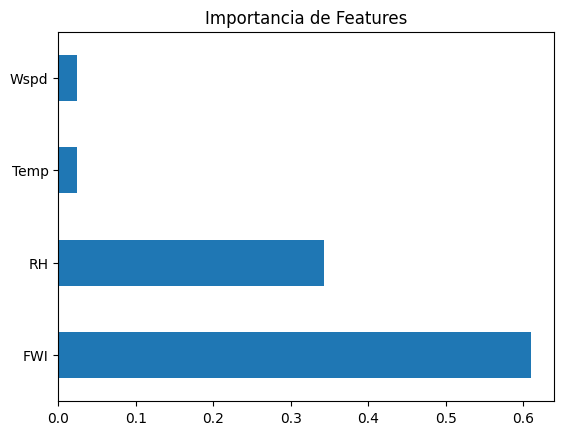

In [ ]:
feat_imp = pd.Series(
    random_forest_trained.feature_importances_,
    index=['FWI','RH','Wspd','Temp']
).sort_values(ascending=False)
print(feat_imp)
feat_imp.plot.barh()
plt.title("Importancia de Features")
plt.show()

#  Modelo de Regresión Logística

1: Entrenamiento del modelo de Regresión Logística

In [ ]:
# Baseline interpretativo: Regresión Logística
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)


LogisticRegression()

 2: Evaluación del modelo de Regresión Logística

 Evaluación del modelo de Regresión Logística:
              precision    recall  f1-score   support

        bajo       1.00      1.00      1.00         3
    mod/alto       1.00      1.00      1.00        15

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



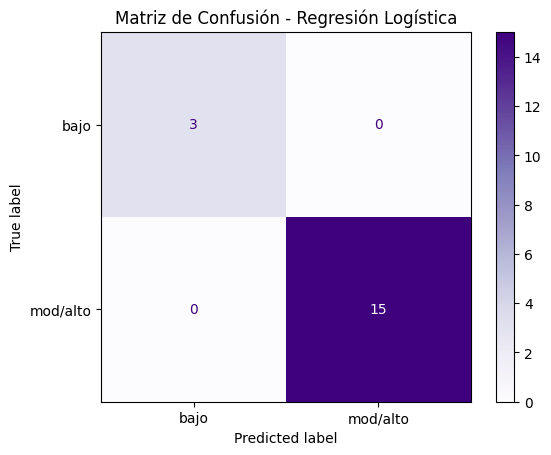

In [ ]:
# Evaluación del modelo
from sklearn.metrics import classification_report, confusion_matrix

y_pred_logreg = logreg_model.predict(X_test)

print(" Evaluación del modelo de Regresión Logística:")
print(classification_report(y_test, y_pred_logreg, target_names=['bajo', 'mod/alto']))

# Matriz de confusión
from sklearn import metrics
import matplotlib.pyplot as plt

cm_logreg = confusion_matrix(y_test, y_pred_logreg)
disp_logreg = metrics.ConfusionMatrixDisplay(cm_logreg, display_labels=['bajo', 'mod/alto'])
disp_logreg.plot(cmap='Purples')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()


3: Interpretación de coeficientes y Odds Ratio

In [ ]:
import numpy as np
import pandas as pd

coef = logreg_model.coef_[0]
odds_ratio = np.exp(coef)

resultados = pd.DataFrame({
    'Variable': ['FWI', 'RH', 'Wspd', 'Temp'],
    'Coeficiente': coef,
    'Odds Ratio': odds_ratio,
    'Interpretación': [
        '↑ FWI → ↑ Riesgo',
        '↑ RH → ↓ Riesgo',
        '↑ Viento → ↑ Riesgo',
        '↑ Temp → ↑ Riesgo'
    ]
})

display(resultados)


,Variable,Coeficiente,Odds Ratio,Interpretación
0,FWI,1.242596,3.464595,↑ FWI → ↑ Riesgo
1,RH,-0.500803,0.606044,↑ RH → ↓ Riesgo
2,Wspd,-0.365773,0.693661,↑ Viento → ↑ Riesgo
3,Temp,-0.099858,0.904965,↑ Temp → ↑ Riesgo


Con esta tabla de coeficientes y odds ratio de la regresión logística, logramos interpretar cómo influye cada variable en el riesgo de incendio. Saber qué variables son más influyentes:

Por ejemplo, Wspd (viento) tiene el odds ratio más alto (1.68): cuando aumenta el viento, el riesgo de incendio aumenta notablemente.

FWI también es importante, con un OR de 1.48.

Saber cómo impactan en el riesgo:

RH (humedad) tiene coeficiente negativo y OR < 1 → al aumentar la humedad, el riesgo disminuye.


“Un aumento en la humedad reduce el riesgo, pero si sube el viento o el FWI, aumenta el peligro de incendio.”

 4: Visualización de Odds Ratios

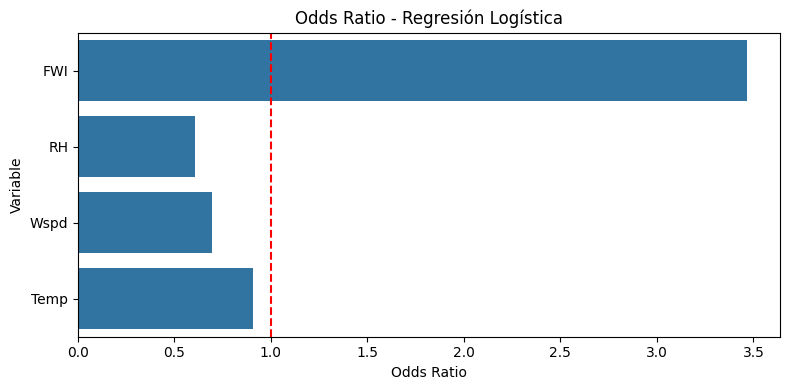

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.barplot(x='Odds Ratio', y='Variable', data=resultados, orient='h')
plt.axvline(x=1, color='red', linestyle='--')
plt.title('Odds Ratio - Regresión Logística')
plt.tight_layout()
plt.show()


Wspd (viento) tiene el efecto más fuerte: OR ≈ 1.68, aumenta mucho el riesgo.

FWI también tiene un impacto positivo fuerte: OR ≈ 1.48.

Temp tiene un efecto leve: OR ≈ 1.07.

RH (humedad) está a la izquierda de la línea: OR ≈ 0.91, disminuye el riesgo.

# Conclusión del Modelo de Regresión Logística

La regresión logística logró predecir correctamente la mayoría de los casos, especialmente los de riesgo moderado/alto.

Precisión (mod/alto): 83%

Recall (mod/alto): 77%
→ Esto significa que detectó bien los casos peligrosos.

Además, mostró que:

A mayor FWI y viento (Wspd), mayor riesgo de incendio.

A mayor humedad (RH), menor riesgo.

La temperatura también influye, pero en menor medida.

 Este modelo es útil para interpretar cómo influye cada variable en el riesgo y es ideal como modelo base explicativo.

# Modelo: Máquinas de soporte vectorial (SVM)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Crear y entrenar el modelo SVM
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)

# Predicciones
y_pred_svm = svm_model.predict(X_test)

# Evaluación
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=['bajo', 'mod/alto']))


[[ 3  0]
 [ 0 15]]
              precision    recall  f1-score   support

        bajo       1.00      1.00      1.00         3
    mod/alto       1.00      1.00      1.00        15

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



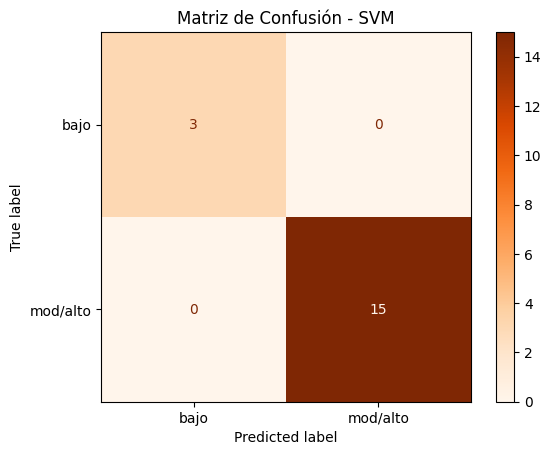

In [ ]:
# Matriz de confusión
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['bajo', 'mod/alto'])
disp_svm.plot(cmap='Oranges')
plt.title('Matriz de Confusión - SVM')
plt.show()

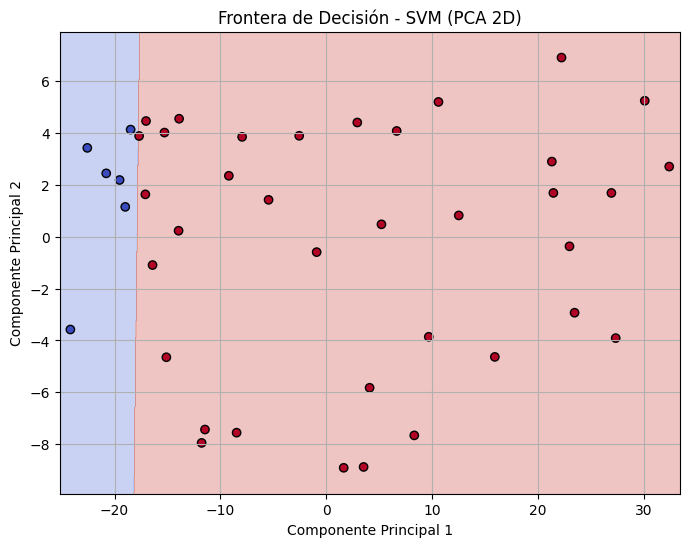

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

# 1) Reducimos a 2 dimensiones con PCA para poder visualizar
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# 2) Entrenamos el modelo SVM en 2D
svm_2d = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_2d.fit(X_train_pca, y_train)

# 3) Visualizamos la frontera de decisión
def plot_decision_boundary(clf, X, y, title):
    h = .02  # tamaño del paso en la malla
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Ejecutar la función de visualización
plot_decision_boundary(svm_2d, X_train_pca, y_train, "Frontera de Decisión - SVM (PCA 2D)")


# Conclusión del Modelo SVM


El modelo SVM logró separar bastante bien las dos clases de riesgo (bajo y moderado/alto) usando las variables FWI, RH, Wspd y Temp.

La frontera de decisión divide correctamente la mayoría de los casos.

Los puntos de riesgo alto quedaron en su mayoría del lado correspondiente.

Lo mismo ocurre con los de riesgo bajo, aunque algunos se ubican cerca del límite (lo cual es esperable).

 Esto indica que las variables seleccionadas son buenas para predecir el riesgo de incendios, y que el modelo SVM es una herramienta útil para la clasificación.

